# 2 Preprocessing

In [1]:
import sys
sys.path.append('./the .py files')  # relative path from notebook to .py directory

import data_loader


In [27]:
# all Functions
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split

def drop_flat_sensors(df):
    """
    Identifies and removes flat (no-variance) sensor columns.

    Parameters:
        df (pd.DataFrame): Engine dataset.

    Returns:
        pd.DataFrame: Cleaned DataFrame with flat sensors removed.
    """
    sensor_cols = [col for col in df.columns if 'sensor' in col]
    flat_sensors = [col for col in sensor_cols if df[col].nunique() == 1]
    return df.drop(columns=flat_sensors)

def summarise_engine_lifespans(df, dataset_name="FD001"):
    """
    Plots and summarises the distribution of engine lifespans for a given C-MAPSS dataset.

    Parameters:
        df (pd.DataFrame): The raw or preprocessed dataset.
        dataset_name (str): Optional label to include in the plot title.

    Returns:
        Tuple: (mean, std, min, max) of engine lifespans.
    """
    max_cycles_per_unit = df.groupby("unit_number")["time_in_cycles"].max()

    # Stats
    mean_cycles = max_cycles_per_unit.mean()
    std_cycles = max_cycles_per_unit.std()
    min_cycles = max_cycles_per_unit.min()
    max_cycles = max_cycles_per_unit.max()

    # Histogram
    plt.figure(figsize=(10, 6))
    plt.hist(max_cycles_per_unit, bins=20, edgecolor='black')
    plt.title(f"Distribution of Engine Lifespans ({dataset_name})")
    plt.xlabel("Max Cycles Before Failure")
    plt.ylabel("Number of Engines")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print(f"Dataset: {dataset_name}")
    print(f"Mean cycles to failure: {mean_cycles:.2f}")
    print(f"Standard deviation: {std_cycles:.2f}")
    print(f"Minimum: {min_cycles}")
    print(f"Maximum: {max_cycles}")

    return mean_cycles, std_cycles, min_cycles, max_cycles


def calculate_rul(df, max_rul=130):
    """
    Calculates Remaining Useful Life (RUL) for each time step and adds it to the DataFrame.

    Parameters:
        df (pd.DataFrame): Engine dataset containing 'unit_number' and 'time_in_cycles'.
        max_rul (int): Maximum RUL value to clip at. Default is 130.

    Returns:
        pd.DataFrame: DataFrame with an additional 'RUL' column.
    """
    df = df.copy()
    max_cycles = df.groupby('unit_number')['time_in_cycles'].transform('max')
    df['RUL'] = (max_cycles - df['time_in_cycles']).clip(upper=max_rul)
    return df


def standardise_per_condition(df):
    """
    Applies z-score standardisation to sensor measurements within each unique operating condition.

    Parameters:
        df (pd.DataFrame): DataFrame with sensor columns and op_setting_1/2/3.

    Returns:
        pd.DataFrame: Standardised DataFrame.
    """
    df = df.copy()
    
    setting_cols = [col for col in df.columns if "op_setting" in col]
    sensor_cols = [col for col in df.columns if "sensor_measurement" in col]

    # Group by condition
    for key, group in df.groupby(setting_cols):
        scaler = StandardScaler()
        df.loc[group.index, sensor_cols] = scaler.fit_transform(group[sensor_cols])

    return df


def generate_sliding_windows(df, seq_len=30):
    """
    Generates sliding windows of sensor data and RUL labels for model training.

    Parameters:
        df (pd.DataFrame): Must include 'unit_number', 'time_in_cycles', 'RUL', and sensor columns.
        seq_len (int): Length of each time window.

    Returns:
        Tuple (X, y): 3D array of sequences and 1D array of RUL targets.
    """
    feature_cols = [col for col in df.columns if "sensor_measurement" in col]
    X, y = [], []

    for unit_id, group in df.groupby("unit_number"):
        group = group.sort_values("time_in_cycles").reset_index(drop=True)
        data = group[feature_cols].values
        target = group["RUL"].values

        if len(group) >= seq_len:
            for i in range(len(group) - seq_len + 1):
                X.append(data[i:i+seq_len])
                y.append(target[i+seq_len-1])  # Label is RUL at end of the window

    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)


def split_by_unit(df, test_size=0.3, random_state=42):
    """
    Splits the DataFrame into training and validation sets based on unique engine IDs.

    Parameters:
        df (pd.DataFrame): Dataset including 'unit_number'.
        test_size (float): Fraction of units to assign to validation set.
        random_state (int): Seed for reproducibility.

    Returns:
        Tuple (train_df, val_df): Split DataFrames by engine ID.
    """
    unit_ids = df['unit_number'].unique()
    train_ids, val_ids = train_test_split(unit_ids, test_size=test_size, random_state=random_state)

    train_df = df[df['unit_number'].isin(train_ids)].reset_index(drop=True)
    val_df = df[df['unit_number'].isin(val_ids)].reset_index(drop=True)

    return train_df, val_df

def subset_by_unit(df, unit_ids):
    """
    Returns a subset of the DataFrame containing only the specified engine units.

    Parameters:
        df (pd.DataFrame): Original dataset.
        unit_ids (array-like): List or array of engine unit numbers.

    Returns:
        pd.DataFrame: Filtered dataset for the specified units.
    """
    return df[df['unit_number'].isin(unit_ids)].reset_index(drop=True)

def make_feature_vectors_from_windows(X, strategy='last'):
    """
    Converts 3D time-series input into 2D feature vectors for use with baseline models.

    Parameters:
        X (np.ndarray): 3D input array (samples, timesteps, features)
        strategy (str): One of ['last', 'mean', 'flat']

    Returns:
        np.ndarray: 2D array of shape (samples, features)
    """
    if strategy == 'last':
        return X[:, -1, :]  # last timestep
    elif strategy == 'mean':
        return X.mean(axis=1)  # mean over time
    elif strategy == 'flat':
        return X.reshape(X.shape[0], -1)  # flatten entire window
    else:
        raise ValueError("Invalid strategy. Choose from 'last', 'mean', or 'flat'.")

def save_preprocessed_data(X_train, y_train, X_val, y_val, X_test, y_test, filename='cmaps_preprocessed.npz'):
    """
    Saves preprocessed datasets to a compressed .npz file.

    Parameters:
        X_train, y_train, X_val, y_val, X_test, y_test (np.ndarray): Data arrays
        filename (str): Output file path

    Returns:
        None
    """
    np.savez_compressed(
        filename,
        X_train=X_train, y_train=y_train,
        X_val=X_val, y_val=y_val,
        X_test=X_test, y_test=y_test
    )
    print(f"Data saved to {filename}")


def load_preprocessed_data(filename):
    """
    Loads preprocessed datasets from a compressed .npz file.

    Parameters:
        filename (str): Path to .npz file.

    Returns:
        Tuple of arrays: (X_train, y_train, X_val, y_val, X_test, y_test)
    """
    data = np.load(filename)
    return (
        data['X_train'], data['y_train'],
        data['X_val'], data['y_val'],
        data['X_test'], data['y_test']
    )


## Write one function that does all the pre_processing

In [ ]:
# build .npz file for testing lstm model functions 

def prepare_lstm_data(file_path, seq_len=30, save_as="fd001_last.npz"):
    """
    Prepares LSTM-ready 3D data from raw C-MAPSS file using pre_processing module.

    Parameters:
        file_path (str): Path to raw FD001 text file.
        seq_len (int): Length of each time window.
        save_as (str): Filename to save the .npz file.

    Returns:
        Tuple: X_train, y_train, X_val, y_val
    """
    # Step 1: Load raw data
    df = data_loader.load_raw_data(file_path)
    
    # Step 2: Drop flat sensors
    df = pre_processing.drop_flat_sensors(df)
    
    # Step 3: Calculate RUL
    df = pre_processing.calculate_rul(df)
    
    # Step 4: Standardise
    df = pre_processing.standardise_per_condition(df)
    
    # Step 5: Generate sliding windows
    X, y = pre_processing.generate_sliding_windows(df, seq_len=seq_len)
    
    # Step 6: Train/val split
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Step 7: Save
    pre_processing.save_preprocessed_data(X_train, y_train, X_val, y_val, X_test=None, y_test=None, filename=save_as)
    
    return X_train, y_train, X_val, y_val


X_train, y_train, X_val, y_val = prepare_lstm_data("CMaps/train_FD001.txt")
print(X_train.shape, y_train.shape)

In [3]:
df = data_loader.load_raw_data("CMaps/train_FD001.txt")
df.head()

,unit_number,time_in_cycles,op_setting_1,op_setting_2,op_setting_3,sensor_measurement_1,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_5,...,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_16,sensor_measurement_17,sensor_measurement_18,sensor_measurement_19,sensor_measurement_20,sensor_measurement_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [4]:
df_clean = drop_flat_sensors(df)
print(df_clean.columns.tolist())


['unit_number', 'time_in_cycles', 'op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_measurement_2', 'sensor_measurement_3', 'sensor_measurement_4', 'sensor_measurement_6', 'sensor_measurement_7', 'sensor_measurement_8', 'sensor_measurement_9', 'sensor_measurement_11', 'sensor_measurement_12', 'sensor_measurement_13', 'sensor_measurement_14', 'sensor_measurement_15', 'sensor_measurement_17', 'sensor_measurement_20', 'sensor_measurement_21']


In [8]:
df_clean = drop_flat_sensors(df)
df_rul = calculate_rul(df_clean)

print(df_rul[['unit_number', 'time_in_cycles', 'RUL']].head(600))

     unit_number  time_in_cycles  RUL
0              1               1  130
1              1               2  130
2              1               3  130
3              1               4  130
4              1               5  130
..           ...             ...  ...
595            3             117   62
596            3             118   61
597            3             119   60
598            3             120   59
599            3             121   58

[600 rows x 3 columns]


# References for 

[Wang et al., 2008]

Wang, T., Yu, J., & Siegel, D. (2008). A similarity-based prognostics approach for remaining useful life estimation of engineered systems.
2008 International Conference on Prognostics and Health Management, IEEE.

Harvard Style:

Wang, T., Yu, J. and Siegel, D., 2008. A similarity-based prognostics approach for remaining useful life estimation of engineered systems. In 2008 International Conference on Prognostics and Health Management (pp. 1-6). IEEE.


## ----

"Although the maximum engine lifespan in the FD001 dataset reaches 362 cycles, the majority of engines fail between 160 and 220 cycles. Following prior literature (Wang et al., 2008), and to prevent long-tailed regression effects and instability in gradient descent, we cap the Remaining Useful Life (RUL) at 130 cycles. This provides a standardised and focused degradation window for model learning and comparability."

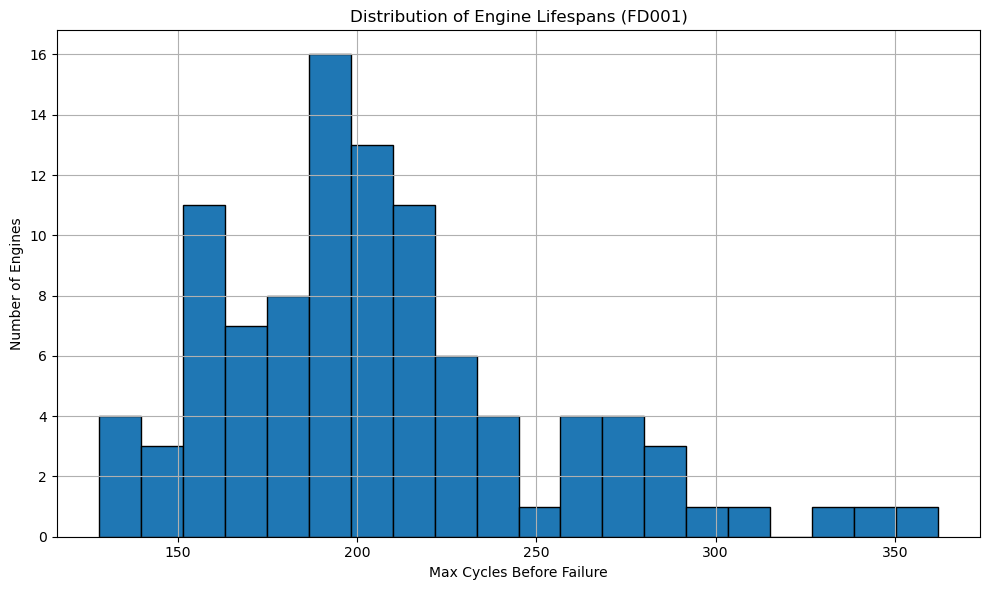

Dataset: FD001
Mean cycles to failure: 206.31
Standard deviation: 46.34
Minimum: 128
Maximum: 362


(206.31, 46.3427492067573, 128, 362)

In [11]:
df_fd001 = data_loader.load_raw_data("CMaps/train_FD001.txt")
summarise_engine_lifespans(df_fd001, dataset_name="FD001")

In [14]:
df_clean = drop_flat_sensors(df)
df_rul = calculate_rul(df_clean)
df_scaled = standardise_per_condition(df_rul)

sensor_cols = [col for col in df_scaled.columns if "sensor_measurement" in col]
df_scaled[sensor_cols].describe()

,sensor_measurement_2,sensor_measurement_3,sensor_measurement_4,sensor_measurement_6,sensor_measurement_7,sensor_measurement_8,sensor_measurement_9,sensor_measurement_11,sensor_measurement_12,sensor_measurement_13,sensor_measurement_14,sensor_measurement_15,sensor_measurement_17,sensor_measurement_20,sensor_measurement_21
count,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04,2.063100e+04
mean,7.100261e-15,3.237411e-16,-8.238177e-16,-9.361145e-14,2.796572e-16,-2.464014e-14,4.192102e-15,-3.140977e-16,1.909383e-15,-3.128027e-14,2.060922e-15,1.184755e-15,-1.157202e-16,2.472831e-15,9.230064e-17
std,9.944831e-01,9.944831e-01,9.945318e-01,6.247443e-01,9.945318e-01,9.943856e-01,9.945318e-01,9.945318e-01,9.945318e-01,9.944831e-01,9.945318e-01,9.944831e-01,9.930686e-01,9.944831e-01,9.945318e-01
min,-3.255012e+00,-3.023272e+00,-2.695591e+00,-7.211103e+00,-3.780872e+00,-2.766334e+00,-2.654050e+00,-2.618929e+00,-3.432902e+00,-2.936303e+00,-2.937688e+00,-2.810029e+00,-2.962780e+00,-3.409408e+00,-3.743584e+00
25%,-7.353976e-01,-7.185581e-01,-7.452126e-01,-3.552714e-15,-6.741812e-01,-7.448107e-01,-6.070006e-01,-7.479474e-01,-6.650406e-01,-7.377106e-01,-6.037870e-01,-7.453690e-01,-7.384328e-01,-6.801107e-01,-6.769993e-01
50%,-5.419871e-02,-5.566610e-02,-9.033860e-02,0.000000e+00,7.191876e-02,-3.823596e-02,-2.047403e-01,-9.139588e-02,7.078720e-02,-4.457830e-02,-1.629945e-01,-6.696574e-02,-7.544932e-02,6.700814e-02,6.052724e-02
75%,6.777583e-01,6.695268e-01,6.747432e-01,1.796053e-01,7.425223e-01,6.659796e-01,3.188039e-01,6.544199e-01,7.595845e-01,6.497516e-01,3.591253e-01,6.638793e-01,6.492024e-01,7.307349e-01,7.405970e-01
max,3.634478e+00,3.811550e+00,3.570310e+00,1.000000e+00,2.957685e+00,4.687090e+00,5.932538e+00,3.508571e+00,2.774734e+00,4.492333e+00,5.974455e+00,3.488498e+00,3.973959e+00,3.174809e+00,3.144426e+00


In [15]:
print(df_scaled['sensor_measurement_2'].mean())
print(df_scaled['sensor_measurement_2'].std())

7.100261276928033e-15
0.994483085267508


In [17]:
X, y = generate_sliding_windows(df_scaled, seq_len=30)
print("Input shape:", X.shape)  # Should be (num_windows, 30, n_features)
print("Target shape:", y.shape)  # Should be (num_windows,)

Input shape: (17731, 30, 15)
Target shape: (17731,)


In [18]:
print("Example X window:\n", X[0])
print("Corresponding y:", y[0])


Example X window:
 [[-1.7644346e+00 -1.8152852e-01 -7.8145236e-01  1.8257418e-01
   8.9007068e-01 -3.2658064e-01 -9.4317228e-01 -1.3012430e-01
   1.4663406e-01 -8.3613241e-01 -4.0804821e-01 -3.4949911e-01
  -7.2620404e-01  1.2313803e+00  1.1671489e+00]
 [-1.0917826e+00  1.9266659e-01 -9.1462904e-01  2.9488391e-01
   3.9554694e-01 -5.6348807e-01 -1.2528487e+00 -2.7546948e-01
   1.3040830e+00 -3.0372837e-01 -8.7707180e-01 -2.4230498e-01
  -7.3129237e-01  1.1040831e+00  1.2990062e+00]
 [-9.4903660e-01 -1.0398265e+00 -1.7469598e+00  0.0000000e+00
   1.8869755e+00 -7.7145427e-01 -1.1273113e+00 -1.7570921e+00
   1.9787699e+00 -1.7186757e+00 -1.1486983e+00 -1.6736729e+00
  -1.9373298e+00  1.4164846e+00  1.3292514e+00]
 [-8.3707511e-01 -1.4251924e+00 -9.2081517e-01  0.0000000e+00
   1.3106482e+00 -1.9401789e-01 -5.5584794e-01 -1.7047328e+00
   2.0465455e+00 -4.7842571e-01 -4.0568718e-01 -2.0967655e+00
  -9.3645883e-01  5.6891060e-01  1.0773904e+00]
 [-7.8070605e-01 -1.0589013e+00 -1.3412964e-0

In [20]:
train_df, val_df = split_by_unit(df_scaled)

print("Train units:", train_df['unit_number'].nunique())
print("Val units:", val_df['unit_number'].nunique())
print("Total units:", df_scaled['unit_number'].nunique())

Train units: 70
Val units: 30
Total units: 100


In [21]:
set(train_df['unit_number']).intersection(set(val_df['unit_number']))

set()

In [24]:
# After splitting earlier
train_df, val_df = split_by_unit(df_scaled)

# Recreate from full set using just the train unit IDs
recreated_train_df = subset_by_unit(df_scaled, train_df['unit_number'].unique())

# Check if identical
print(len(train_df), len(recreated_train_df))  # should match

14507 14507


In [26]:
X_baseline = make_feature_vectors_from_windows(X, strategy='last')
print(X_baseline.shape)  # Should be (samples, features)

(17731, 15)
